# data-scientist-technical-test

I have structured my submission around two key steps :
- loading and analysis of the data
- model training and validation

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from IPython.display import clear_output

## loading and analysis of the data

Here, the data is loaded in two dataframes.
I print some statistics about the data in order to better understand the different features.

The first thing that I find out is that there is a lot of data missing (nan in the dataframe) both in the training set and the test set. For categorical features, the abscence of a value is treated as just an other category. I choose to deel with the abscence of a continuous feature by adding a flag indicating if the feature was present or not in the original data. Then, the mean of the continuous feature is added in place of the missing feature.

In [2]:
data_path = "data/auto-insurance-fall-2017/{}_auto.csv"

test_df = pd.read_csv(data_path.format("test"))
train_df = pd.read_csv(data_path.format("train"))

def print_infos (df):
    col_infos = df.dtypes.to_frame().rename(columns={0: "dtypes"})
    col_infos ["nunique"] = df.nunique()
    col_infos["nans"] = df.isna().sum()
    print(col_infos)


print_infos(test_df)
print_infos(train_df)


              dtypes  nunique  nans
INDEX          int64     2141     0
TARGET_FLAG  float64        0  2141
TARGET_AMT   float64        0  2141
KIDSDRIV       int64        4     0
AGE          float64       54     1
HOMEKIDS       int64        6     0
YOJ          float64       20    94
INCOME        object     1803   125
PARENT1       object        2     0
HOME_VAL      object     1397   111
MSTATUS       object        2     0
SEX           object        2     0
EDUCATION     object        5     0
JOB           object        8   139
TRAVTIME       int64       83     0
CAR_USE       object        2     0
BLUEBOOK      object     1417     0
TIF            int64       21     0
CAR_TYPE      object        6     0
RED_CAR       object        2     0
OLDCLAIM      object      834     0
CLM_FREQ       int64        6     0
REVOKED       object        2     0
MVR_PTS        int64       13     0
CAR_AGE      float64       27   129
URBANICITY    object        2     0
              dtypes  nuniqu

When exploring the database, even if I do not know what "YOJ" and "OLDCLAIM" means exactly, I can see that there is some kind of peculiar thing at YOJ=0
Thus, to help the neural network, I add a flag that indicates wether the YOJ (resp OLDCLAIM) is zero or not.

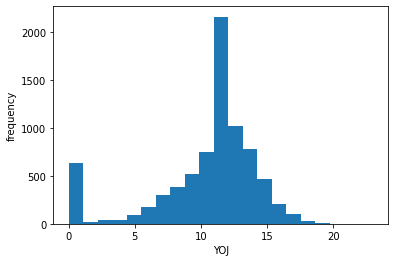

In [3]:
to_plot = "YOJ" # "OLDCLAIM"
plt.hist(train_df[to_plot], bins=21)
plt.xlabel(to_plot)
plt.ylabel("frequency")
plt.show()

Based on the previous discoveries I can format the data so that is is easy to feed to the neural network.

In [4]:
# Here we define a bunch of functions that will help us process the data from a pandas dataframe to a numpy array.

def to_one_hot (col):
    collist = col.tolist()
    index_dic = {key: index for index, key in enumerate(set(collist))}
    res = tf.one_hot([index_dic[x] for x in collist], len(index_dic)).numpy()
    return res

def to_float_trivia (col):
    to_return = np.array(col.tolist(), dtype=np.float32).reshape((-1,1))
    return to_return

def to_float (col):
    to_return = np.array(col.tolist(), dtype=np.float32).reshape((-1,1))
    is_nan = np.isnan(to_return)
    to_return[np.where(is_nan)] = np.nanmean(to_return)
    to_return = (to_return - np.mean(to_return)) / np.std(to_return)
    return to_return
    
def to_float_except (col, value):
    to_return = np.array(col.tolist(), dtype=np.float32).reshape((-1,1))
    is_nan = np.isnan(to_return)
    is_diff = np.where(np.logical_and(to_return != value, 1-is_nan))
    to_return = (to_return - np.mean(to_return[is_diff])) / np.std(to_return[is_diff])
    to_return[np.where(is_nan)] = 0
    return to_return

def flag (col, value):
    return (np.array(col.tolist()) == value).astype(np.float32).reshape((-1,1))

def flag_type (col, test_type):
    return np.array([type(elem)==test_type for elem in col.tolist()]).astype(np.float32).reshape((-1,1))

def flag_nan (col):
    return np.isnan(np.array(col.tolist())).astype(np.float32).reshape((-1,1))

def text_to_float (regex, col):
    collist = col.tolist()
    to_return = []
    for text in collist:
        if type(text) == float:
            to_return.append(text)
        else:
            m = re.search(regex, text) if text is not None else False
            if m:
                to_return.append(float(m.group(1).replace(',', '.')))
            else:
                raise NameError("Could not parse text '{}' with regex '{}'".format(text, regex))

    to_return = np.array(to_return)
    is_nan = np.isnan(to_return)
    to_return[np.where(is_nan)] = np.nanmean(to_return)
    to_return = (to_return - np.mean(to_return)) / np.std(to_return)
    return to_return.reshape((-1,1))

# Here we define the correspondance between the features in the dataframe and the function that we should apply to them

feature_funcs = {
    "KIDSDRIV": to_one_hot,
    "AGE" : lambda x: np.concatenate([to_float(x), flag_nan(x)], axis=1),
    "HOMEKIDS" : to_one_hot,
    "YOJ" : lambda x: np.concatenate([to_float_except(x, 0.), flag(x, 0.)], axis=1),
    "INCOME" : lambda x: np.concatenate([text_to_float("\$(.+)", x), flag_type(x, float)], axis=1),
    "PARENT1" : to_one_hot,
    "HOME_VAL" : lambda x: np.concatenate([text_to_float("\$(.+)", x), flag_type(x, float)], axis=1),
    "MSTATUS" : to_one_hot,
    "SEX" : to_one_hot,
    "EDUCATION" : to_one_hot,
    "JOB" : to_one_hot,
    "TRAVTIME" : to_float,
    "CAR_USE" : to_one_hot,
    "BLUEBOOK" : lambda x: text_to_float("\$(.+)", x),
    "TIF" : to_float,
    "CAR_TYPE" : to_one_hot,
    "RED_CAR" : to_one_hot,
    "OLDCLAIM" : lambda x: np.concatenate([text_to_float("\$(.+)", x), flag(x, "$0")], axis=1),
    "CLM_FREQ" : to_one_hot,
    "REVOKED" : to_one_hot,
    "MVR_PTS" : to_float,
    "CAR_AGE" : lambda x: np.concatenate([to_float(x), flag_nan(x)], axis=1),
    "URBANICITY" : to_one_hot,
}

target_funcs = {
    "TARGET_FLAG": to_float_trivia,
    "TARGET_AMT" : lambda x: to_float_except(x, 0.),
}

# This function goes through the dataframe df and applies the funcs to the right columns to make the numpy we use as dataset.

def prepare_dataset (df, funcs):
    all_features = []
    all_feature_source = []
    for key, func in funcs.items():
        new_features = func(df[key])
        all_features.append(new_features)
        all_feature_source.extend([key for i in range(new_features.shape[1])])
    all_features = np.concatenate(all_features, axis=1)
    return all_features, all_feature_source

n_train = len(train_df.index)
n_test = len(test_df.index)

full_df = pd.concat([train_df, test_df], axis=0)

full_features, full_features_source = prepare_dataset(full_df, feature_funcs)
train_targets, train_targets_source = prepare_dataset(train_df, target_funcs)
train_features = full_features[:n_train]
test_features = full_features[n_train:]

print("train_features :", train_features.shape)
print("train_targets :", train_targets.shape)
print("test_features :", test_features.shape)

train_features : (8161, 67)
train_targets : (8161, 2)
test_features : (2141, 67)


2021-12-01 20:00:02.849660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 20:00:02.860947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 20:00:02.861360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 20:00:02.862186: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Before training the neural network, I want to eliminate the redondant variable to hopefully generalize better to unseen data. In order to do that, I calculate the cross-correlation between the features and the targets. 

The first thing that we see is that the targets are not much correlated to anything. 

Secound thing, we see that some features are greatly correlated between one-another. Thus, we can hopefully remove some of those and still get a good accuracy (that hypothesis is not checked within this notebook).

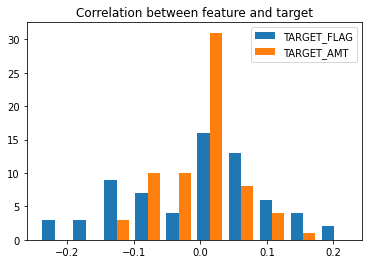

The most important cross-correlations between the features : 
                                 0       abs
YOJ - JOB                 0.426321  0.426321
JOB - CAR_USE             0.438054  0.438054
HOME_VAL - MSTATUS       -0.446291  0.446291
OLDCLAIM - MVR_PTS       -0.467214  0.467214
CLM_FREQ - MVR_PTS       -0.467214  0.467214
OLDCLAIM - CLM_FREQ      -0.470275  0.470275
PARENT1 - MSTATUS        -0.477228  0.477228
KIDSDRIV - HOMEKIDS       0.480308  0.480308
BLUEBOOK - CAR_TYPE       0.487637  0.487637
EDUCATION - CAR_AGE       0.490800  0.490800
AGE - HOMEKIDS            0.495245  0.495245
HOMEKIDS - PARENT1        0.529131  0.529131
TARGET_FLAG - TARGET_AMT  0.534246  0.534246
SEX - CAR_TYPE            0.534681  0.534681
EDUCATION - JOB           0.599275  0.599275
SEX - RED_CAR             0.666621  0.666621


In [5]:
# Shows that there is very little correlation between the targets and the features.
all_data = np.concatenate([train_targets, train_features], axis=1)
corr = np.corrcoef(all_data.T)
plt.hist(corr[2:, :2], label=["TARGET_FLAG","TARGET_AMT"])
plt.legend()
plt.title("Correlation between feature and target")
plt.show()

# Picks up the most important couplings between the features.

all_sources = train_targets_source + full_features_source
interesting_coupling = {}
for i, row in enumerate(corr):
    for j, value in enumerate(row):
        if 0.4 < np.abs(value) < 0.98 and i < j and all_sources[i] != all_sources[j]:
            key = "{} - {}".format(all_sources[i], all_sources[j])
            if key not in interesting_coupling:
                interesting_coupling[key] = value
            else:
                interesting_coupling[key] = value if abs(interesting_coupling[key]) < value else interesting_coupling[key]

df = pd.DataFrame.from_dict(interesting_coupling, orient="index")
df["abs"] = abs(df[0])
df = df.sort_values("abs")
print("The most important cross-correlations between the features : ")
print(df)

Thus, I remove YOJ, CAR_USE, CAR_AGE from the feature set and rebuild the dataset.

In [6]:
del feature_funcs["YOJ"]
del feature_funcs["CAR_USE"]
del feature_funcs["CAR_AGE"]


full_features, full_features_source = prepare_dataset(full_df, feature_funcs)
train_targets, train_targets_source = prepare_dataset(train_df, target_funcs)
train_features = full_features[:n_train]
test_features = full_features[n_train:]

print("train_features :", train_features.shape)
print("train_targets :", train_targets.shape)
print("test_features :", test_features.shape)

train_features : (8161, 61)
train_targets : (8161, 2)
test_features : (2141, 61)


## model training and validation

The model I choose for this task is a neural network as it can deal with both categorical and continuous data. 

Due to the limited amount of data that I have, I need to be very carefull not to overfit. Thus, in the training process, I split the data between a training and a validation set. The neural network is trained on the training set, but I set my hyperparameters in order to make the loss on the validation go as low as possible.

The loss is split in two parts as we are trying to fit two things. The TARGET_FLAG is a binary value (0 or 1) while the TARGET_AMT is a continuous value. I use a binary cross entropy loss to fit the TARGET_FLAG and a mean square loss to fit the TARGET_AMT.

best validation loss : 3.5162830352783203


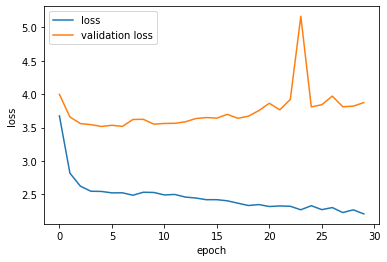

In [7]:

l1_ker = 0.003
l2_ker = 0.00
l1_act = 0.00
l2_act = 0.00

def create_simple_model ():
    return tf.keras.Sequential([ 
        tf.keras.layers.Dense(64,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_ker, l2=l2_ker),
            activity_regularizer=tf.keras.regularizers.L1L2(l1=l1_act, l2=l2_act),
            activation=tf.nn.relu,
            input_shape=[train_features.shape[1]]
        ),
        tf.keras.layers.Dense(64,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_ker, l2=l2_ker),
            activity_regularizer=tf.keras.regularizers.L1L2(l1=l1_act, l2=l2_act),
            activation=tf.nn.relu,
        ),
        tf.keras.layers.Dense(2, activation=None)
    ]
    )


def custom_loss(y_actual,y_pred):
    target_flag = y_actual[:,0]
    log_p_pred = y_pred[:,0]
    
    bce = tf.losses.BinaryCrossentropy(from_logits=True)
    cat_loss = bce(target_flag, log_p_pred) * .3

    actual_value = y_actual[:,1]
    pred_value = y_pred[:,1]

    value_loss = tf.square(actual_value - pred_value) * target_flag * 10

    custom_loss = cat_loss + value_loss
    return custom_loss

def train_model (use_validation, epochs=30):
    """Trains a neural network on the data previously definded.

    Keyword arguments:
    use_validation -- wether to split the data between training and validation or not.
    epochs -- the number of epoch to train the neural network for (default 30)
    """
    optimizer=tf.keras.optimizers.Adam(0.003)

    model = create_simple_model()
    model.compile(loss=custom_loss,optimizer=optimizer)

    cur_train_size = int(.7*n_train) if use_validation else n_train
    x = train_features[:cur_train_size]
    y = train_targets[:cur_train_size]
    if use_validation:
        x_val = train_features[cur_train_size:]
        y_val = train_targets[cur_train_size:]
        history = model.fit(x,y,batch_size=8,epochs=30, validation_data=(x_val, y_val))
        clear_output(wait=True)

        plt.plot(history.history["loss"], label="loss")
        plt.plot(history.history["val_loss"], label="validation loss")
        print("best validation loss :", min(history.history["val_loss"]))
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.show()

        return model, x, y, x_val, y_val, history
    else:
        history = model.fit(x,y,batch_size=8,epochs=epochs)
        clear_output(wait=True)
        plt.plot(history.history["loss"], label="loss")
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.show()

        return model, x, y, history

model, x, y, x_val, y_val, history = train_model(True)

Then we can plot the predicted value of TARGET_AMT against the true value of TARGET_AMT on the validation set (note that the data is scaled to have 0 mean and 1 standard variation). We can see that our neural network has a pretty poor fit to the data : it seems pretty conservative in its prediction by grouping everyone around the mean.

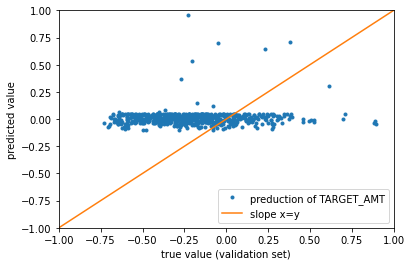

In [8]:
wh = np.where(y_val[:,0] == 1.)
plt.plot(y_val[wh][:,1], model.predict(x_val)[wh][:,1], ".", label="preduction of TARGET_AMT")
plt.plot([-1, 1], [-1, 1], label="slope x=y")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("true value (validation set)")
plt.ylabel("predicted value")
plt.legend()
plt.show()

At the contrary, the TARGET_FLAG seems to be better resolved. The neural network seems to have some idea as to when the TARGET_FLAG should be equal to 1 (orange hist).

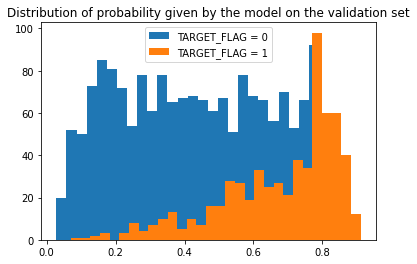

In [9]:
pred = 1/(1+np.exp(-model.predict(x_val)[:,0]+np.mean(model.predict(x_val)[:,0])))
pred_0 = pred[np.where(y_val[:,0] == 0.)]
pred_1 = pred[np.where(y_val[:,0] == 1.)]
plt.hist(pred_0, density=False, bins=30, label="TARGET_FLAG = 0")
plt.hist(pred_1, density=False, bins=30, label="TARGET_FLAG = 1")
plt.legend()
plt.title("Distribution of probability given by the model on the validation set")
plt.show()

## Last touch

Finally, once we have the best hyperparameters, we can train a final network on the full training dataset and save its predictions on a separate file.  

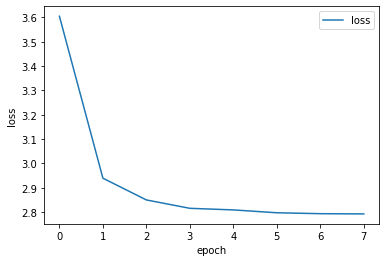

In [10]:
model, x, y, history = train_model(False, epochs=8)

In [12]:
raw_train_pred = model(train_features).numpy()
raw_test_pred = model(test_features).numpy()

# We need to retrieve the mean and the std that we used to preprocess the data in order to scale back the prediction of the neural network
def to_float_except_mean_std (col, value):
    to_return = np.array(col.tolist(), dtype=np.float32).reshape((-1,1))
    is_nan = np.isnan(to_return)
    is_diff = np.where(np.logical_and(to_return != value, 1-is_nan))
    return np.mean(to_return[is_diff]), np.std(to_return[is_diff])

m, s = to_float_except_mean_std(train_df["TARGET_AMT"], 0.)

pred_target_flag = (raw_test_pred[:,0] > 0).astype(np.float32)
pred_target_amt = raw_test_pred[:,1] * s + m
pred_target_amt[np.where(pred_target_flag==0)] = 0

test_df["TARGET_FLAG"] = pred_target_flag
test_df["TARGET_AMT"] = pred_target_amt
 
test_df.to_csv(data_path.format("test_results"))
